# AA Module Class

## Imports

In [1]:
import numpy as np
import pandas as pd 
import random 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits import mplot3d

from scipy.special import softmax
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
import torch.optim as optim

from timeit import default_timer as timer
import sys

from sklearn.decomposition import PCA

## Conventional AA Class
This class is responsible for doing conventional Archetypal Analisys on given data.

In [2]:
class _conventional_AA:
    
    def _error(self, X,B,A):
        return torch.norm(X - X@B@A, p='fro')**2
    
    def _apply_constraints(self, A):
        m = nn.Softmax(dim=0)
        return m(A)
    
    def _compute_archetypes(self, X, N, K, n_iter, lr, mute):
        
        start = timer()
        
        if not mute:
            bar = _loading(n_iter, "Conventional Arhcetypal Analysis")
        
        Xt = torch.tensor(X,requires_grad=False).float()
        A = torch.autograd.Variable(torch.rand(K, N), requires_grad=True)
        B = torch.autograd.Variable(torch.rand(N, K), requires_grad=True)
        
        optimizer = optim.Adam([A, B], amsgrad = True, lr = 0.01)

        for i in range(n_iter):
            if not mute:
                bar._update()
            optimizer.zero_grad()
            L = self._error(Xt, self._apply_constraints(B), self._apply_constraints(A))
            L.backward()
            optimizer.step()
            
            
        A = self._apply_constraints(A)
        B = self._apply_constraints(B)
        
        end = timer()
        
        # Compute the final error
        RSS = self._error(Xt, B, A)
        
        if not mute:
            print("/////////////// INFORMATION ABOUT ANALYSIS \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
            print("▣ It took ", round(end-start,2), " seconds for the algorithm to converge.")
            print("▣ The final RSS was: {0}.".format(round(RSS.item(),2)))
            print("▣ Sucessfully computed the archetypes!")
        
        return A.detach().numpy(), B.detach().numpy(), RSS.item(), (Xt@B).detach().numpy(), round(end-start,2)

## Ordinal AA Class
This class is responsible for doing ordinal Archetypal Analysis on given data.

## Plotter Class
This class is responsible for creating barplots of results of Archetypal Analysis.

In [3]:
class _plotter():
    
    def _plot(self, plot_type, AA_type, columns, ordinal_result, conventional_result, X, save_fig, subset):
        if AA_type == "all" or AA_type == "conventional":
            
            if conventional_result is None:
                print("You have to do a Conventional Archetypal Analysis before plotting the results.")
                
            else:
                
                if plot_type == "all" or plot_type == "barplot":
                    print("/////////////// BARPLOTS OF CONVENTIONAL \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
                    self._barplot(conventional_result.Z,columns)
                    
                elif plot_type == "all" or plot_type == "barplot_2":
                    print("/////////////// BARPLOTS OF CONVENTIONAL \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
                    self._barplot_2(conventional_result.Z,columns)
                    
                elif plot_type == "all" or plot_type == "scatter_plot":
                    print("/////////////// SCATTER-PLOTS OF CONVENTIONAL \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
                    self._scatter_plot(conventional_result.Z,X,columns)
                    
                elif plot_type == "all" or plot_type == "scatter_plot_3d":
                    print("/////////////// 3D SCATTER-PLOTS OF CONVENTIONAL \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
                    self._scatter_plot_3d(conventional_result.Z,X,columns)
                    
                else:
                    print("The plot_type \"{0}\" specified, does not match any of the possible AA_types.".format(plot_type))
                
        elif AA_type == "all" or AA_type == "ordinal":
            
            if ordinal_result is None:
                print("You have to do an Ordinal Archetypal Analysis before plotting the results.")
                
            else:
                if plot_type == "all" or plot_type == "barplot":
                    print("NOT IMPLEMENTED")
                    
                elif plot_type == "all" or plot_type == "barplot_2":
                    print("NOT IMPLEMENTED")
                    
                elif plot_type == "all" or plot_type == "scatter_plot":
                    print("NOT IMPLEMENTED")
                    
                elif plot_type == "all" or plot_type == "scatter_plot_3d":
                    print("NOT IMPLEMENTED")
                    
                else:
                    print("The plot_type \"{0}\" specified, does not match any of the possible AA_types.".format(plot_type))
        
        else:
            print("The AA_type \"{0}\" specified, does not match any of the possible AA_types.".format(AA_type))
        
        
    def _barplot(self,Z,columns):
        archetype_num = 1
        for archetype in Z.T:
            fig, ax = plt.subplots()
            ax.set_ylabel('Value')
            ax.set_title('Archeype {0}'.format(archetype_num))
            ax.bar(np.arange(len(archetype)),archetype)
            ax.set_xticks(np.arange(len(archetype)))
            ax.set_xticklabels(labels=columns)
            plt.ylim(np.min(Z-1), np.max(Z+1))
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            
            fig.set_size_inches(8, 8)
            
            plt.show()
            
            archetype_num += 1
            
            
    
    def _barplot_2(self,Z,columns):
        data = []
        names = ["Attributes"]
        
        for (arch, column) in zip(Z,columns.to_numpy()):
            current_data = [column]
            for value in arch:
                current_data.append(value)
                
            data.append(current_data)
        
        for i in range(len(Z.T)):
            names.append("Archetype {0}".format(i+1))

        df=pd.DataFrame(data,columns=names)
        df.plot(x="Attributes", y=names[1:], kind="bar",figsize=(12,12))
        plt.show()
    
            
    
    def _scatter_plot(self,Z,X,columns):
        
        pca = PCA(n_components=2)
        pca.fit(Z.T)
        
        Z_pca = pca.transform(Z.T)
        X_pca = pca.transform(X.T)
        
        #line_1 = []
        #line_2 = []
        #lines = []
        #distances = []
        
        #for arch in Z_pca:
        #    for other in Z_pca:
        #        lines.append([arch[0],arch[1],other[0],other[1]])
        #        distances.append(np.linalg.norm(np.mean([arch,other], axis = 1)))
        #        line_1.append(arch[0])
        #        line_1.append(other[0])
        #        line_2.append(arch[1])
        #        line_2.append(other[1])
        
        plt.rcParams["figure.figsize"] = (10,10)
        #plt.plot(line_1, line_2, '-', c = "red", linewidth=0.5)
        plt.scatter(X_pca[:,0], X_pca[:,1], c ="blue", s = 3)
        plt.scatter(Z_pca[:,0], Z_pca[:,1], marker ="^", c ="red", s = 450)
        
        plt.show()
        
        
    def _scatter_plot_3d(self,Z,X,columns):
        
        pca = PCA(n_components=3)
        pca.fit(Z.T)
        
        Z_pca = pca.transform(Z.T)
        X_pca = pca.transform(X.T)
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')

        ax.scatter3D(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=X_pca[:,2], cmap='Greens', alpha=0.5);
        ax.scatter3D(Z_pca[:,0], Z_pca[:,1], Z_pca[:,2], c='Red', s = 400);
        
        plt.show()
        
        
        

## AA result Class
This class is responsible for storing the results for the different AA performed by the user.

In [4]:
class _AA_result:
    
    def __init__(self, A, B, RSS, Z, K, time):
        self.A = A
        self.B = B
        self.RSS = RSS
        self.Z = Z
        self.K = K
        self.time = time

## Loading Screen Class
This class is responsible for the UI during the loading phase.

In [5]:
class _loading:
    
    def __init__(self, count, headline):
        self.count = count
        self.current = 0
        self.skip = 0
        print("{0} in progress...".format(headline))
        
    def _update(self):
        self.current += 1
        if self.current == self.count:
            print("\r{0}".format("Finished Successfully!                               \n"))
        elif self.skip > self.count/133:
            print("\r{0}".format("|{0}{1}|   {2}% finished.".format("█"*int(round(self.current/self.count,1)*20),"-"*(20-int(round(self.current/self.count,1)*20)),round((self.current/self.count)*100,2))), end = "", flush=True)
            self.skip = 0
            
        else:
            self.skip += 1
            
            

## Module Class
This class is responsible for handling the user interaction.

In [6]:
class AAM:
    
    def __init__(self, filename, columns = None, rows = None):
        self._clean_data(filename, columns, rows)
        
        self._conventional_AA = _conventional_AA()
        self._conventional_AA_result = None
        self._ordinal_AA = None
        self._ordinal_AA_result = None
        self._plotter = _plotter()
        
    
    def _clean_data(self, filename, columns, rows):
        df = pd.read_csv(filename)
        
        if not columns is None:
            X = df[columns]
        else:
            X = df
        
        self.columns = X.columns
        
        if not rows is None:
            X = X.iloc[range(rows),:]
        
        X = X.to_numpy().T
        
        self.M, self.N = X.shape
        self.X = X
    
    
    def analyse(self, K, n_iter, AA_type = "all", lr = 0.001, mute = False):
        if AA_type == "all" or AA_type == "conventional":
            A, B, RSS, Z, time = self._conventional_AA._compute_archetypes(self.X, self.N, K, n_iter, lr, mute)
            self._conventional_AA_result = _AA_result(A,B,RSS,Z,K,time)
        elif AA_type == "all" or AA_type == "ordinal":
            print("NOT IMPLEMENTED")
        else:
            print("The AA_type \"{0}\" specified, does not match any of the possible AA_types.".format(AA_type))
        
        
    def plot(self, plot_type = "all", AA_type = "all", save_fig = "False", subset = None):
        self._plotter._plot(plot_type, 
                            AA_type, 
                            self.columns, 
                            self._ordinal_AA_result, 
                            self._conventional_AA_result, 
                            self.X,
                            save_fig,
                            subset)
    

# TESTING

In [7]:
filename = 'ESS8_data.csv'
columns = ['SD1', 'PO1', 'UN1', 'AC1', 'SC1',
       'ST1', 'CO1', 'UN2', 'TR1', 'HD1', 'SD2','BE1','AC2', 'SC2', 'ST2',
       'CO2', 'PO2', 'BE2', 'UN3', 'TR2','HD2']
rows = 10000
aam = AAM(filename, columns, rows)

In [8]:
aam.analyse(5, 10000, AA_type = "conventional")

Conventional Arhcetypal Analysis in progress...
Finished Successfully!                               

/////////////// INFORMATION ABOUT ANALYSIS \\\\\\\\\\\\\\\\
▣ It took  33.92  seconds for the algorithm to converge.
▣ The final RSS was: 161889.28.
▣ Sucessfully computed the archetypes!


/////////////// SCATTER-PLOTS OF CONVENTIONAL \\\\\\\\\\\\\\\\


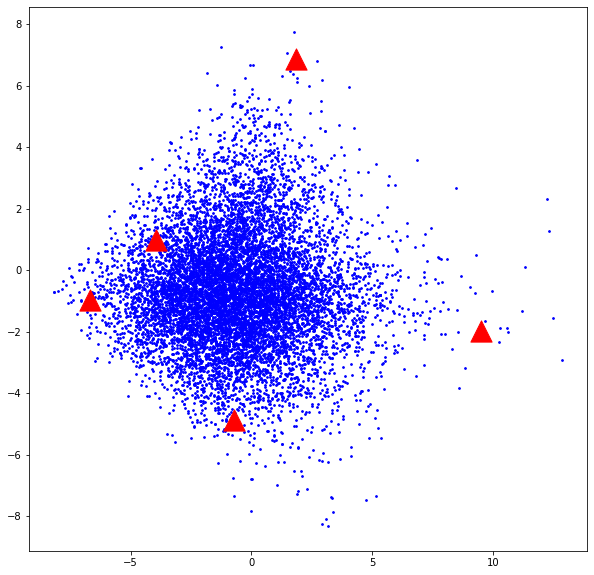

In [12]:
aam.plot(plot_type = "scatter_plot", AA_type = "conventional")

/////////////// BARPLOTS OF CONVENTIONAL \\\\\\\\\\\\\\\\


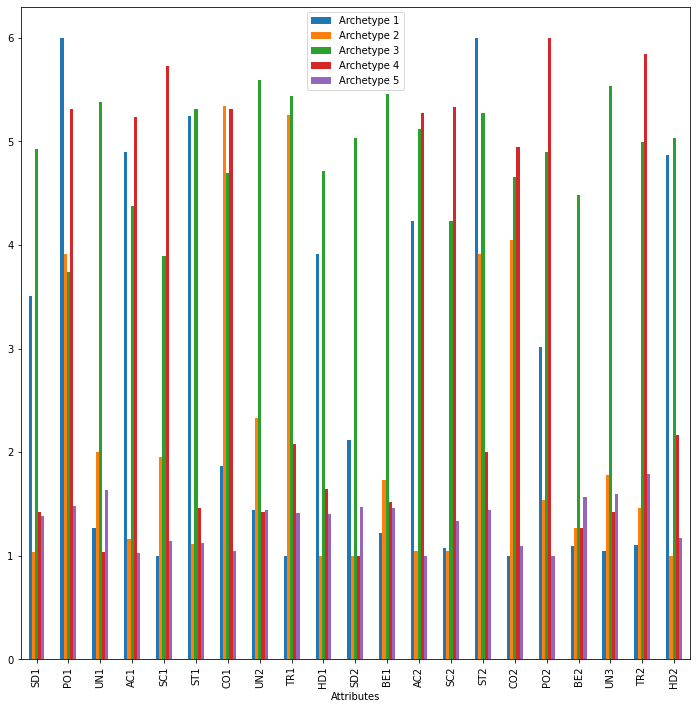

In [13]:
aam.plot(plot_type = "barplot_2", AA_type = "conventional")

/////////////// BARPLOTS OF CONVENTIONAL \\\\\\\\\\\\\\\\


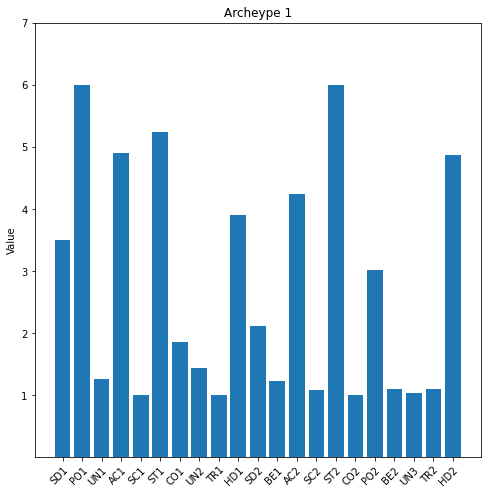

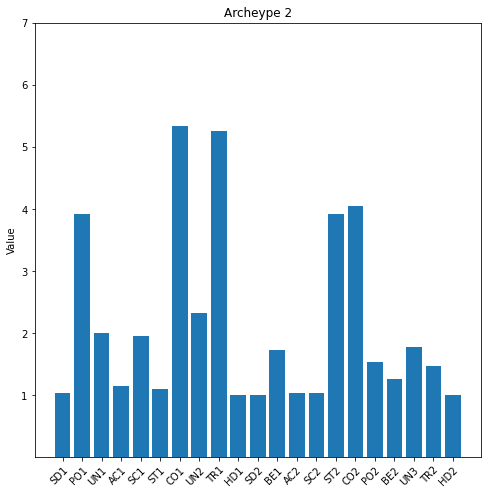

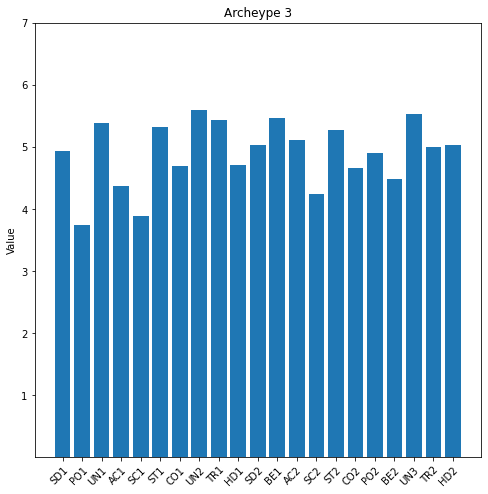

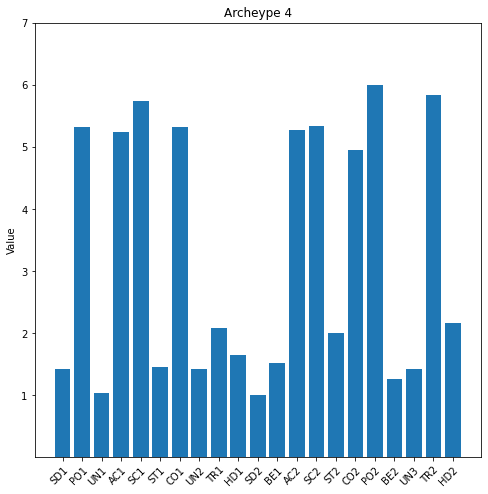

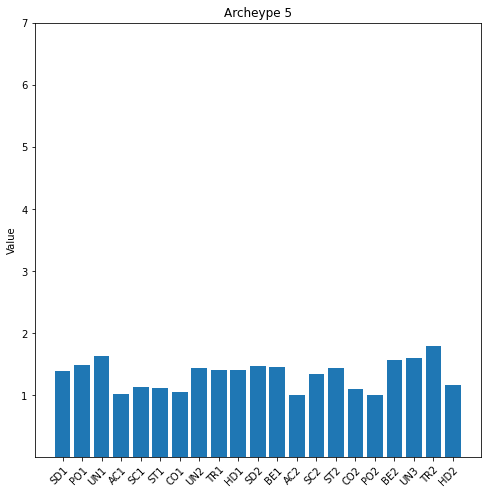

In [11]:
aam.plot(plot_type = "barplot", AA_type = "conventional")